## DEMENT in parallel

In [1]:
#..Load modules
import os
import sys
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
from plotnine import *

In [2]:
from initialization_gradcatch import initialize_data
from grid_gradcatch import Grid
from output_gradcatch import Output
from utility import export

In [3]:
input_folder  = "input"   # input folder name
#...Set up the working directory
os.chdir(input_folder)

In [5]:
import joblib
from joblib import Parallel, delayed

In [6]:
def dement(outname, random_seed):
    #outname_t[i]  = "20220221" + str(int(i))    # output file name and seed of Pseudo-RNG + "20220211"
    input_folder  = "input"   # input folder name 
    output_folder = "output"  # output folder name
    #outname       = outname_t[i]
    #outname       = "20220131"   # output file name and seed of Pseudo-RNG
    #...Set up the working directory
    #  os.chdir(input_folder)
    #...seed the pseudorandom number generator
    np.random.seed(random_seed)

    #...a few system constants
    runtime    = pd.read_csv('runtime.txt',header=None,index_col=0,sep='\t')
    pulse      = int(runtime.loc['pulse',1])         # number of pulses
    cycle      = int(runtime.loc['end_time',1])      # number of time steps in each pulse
    interval   = int(runtime.loc['interval',1])      # interval of time step to record outputs
    mic_reinit = True    # indicate reinitialization of microbial community

    #...Initialize data by calling the Function: Initialize_Data()
    data_initialization = initialize_data(runtime)

    #...Prepare for output by creating an instance of the Output class
    Output_init = Output(runtime,data_initialization)

    #...Create an instance of the Grid class
    Ecosystem = Grid(runtime,data_initialization)

    #...Run the model
    for p in range(pulse):
    
        for i in range(p*cycle, (p+1)*cycle):
    
            # substrates degradation
            Ecosystem.degradation(p,i)

            # monomers uptake
            Ecosystem.uptake(p,i)

            # microbial metabolism
            Ecosystem.metabolism(i)

            # microbial death
            Ecosystem.mortality(i)

            # microbial reproduction and dispersal
            Ecosystem.reproduction(i)
    
            # output data using the "output" method in the Output class
            if i == 0:
                Output_init.output(Ecosystem,i)  # day 1
            elif i%interval==interval-1:
                Output_init.output(Ecosystem,i)  # interval
        
            # if only 1 pusle, skip all following lines within this loop
            #if pulse == 1:
            #    continue

            # output microbial mass of every iteration using the "microbes_df" method in the Output class
            Output_init.microbes_abundance(Ecosystem,i)

            # re-initialize microbial community in each new pulse
            if i == (p+1)*cycle-1:
                Ecosystem.repopulation(Output_init,i,mic_reinit)

    return Output_init

results = Parallel(n_jobs=2)(delayed(dement)("20240331" + str(int(i)),i) for i in range(2))

## Saving the model output

In [7]:
import pickle
output = open('C:/luciana_datos/UCI/Project_14 (Anna)/DEMENT_gradcatch/DEMENT/SP05/output/results_dement5.pkl', 'wb')
pickle.dump(results, output)
output.close()

## Open the pickle output

In [8]:
#import pprint
pkl_file = open('C:/luciana_datos/UCI/Project_14 (Anna)/DEMENT_gradcatch/DEMENT/SP05/output/results_dement5.pkl', 'rb')
test     = pickle.load(pkl_file)
pkl_file.close()

## Test Plots

In [9]:
tt        = np.linspace(0,1,2) # Number of repetitions = 4
time      = np.linspace(0,365*2,365*2+1)

### Respiration

In [10]:
respi_base     = []

for i in tt:
        respi_base.append(test[int(i)].RespSeries)

Respi_mean = (np.array(respi_base).mean(axis=0))
respiration_5  = np.percentile(respi_base,5,axis=0)
respiration_95 = np.percentile(respi_base,95,axis=0)

C:\Users\lucia\AppData\Local\Temp\ipykernel_16888\187784392.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


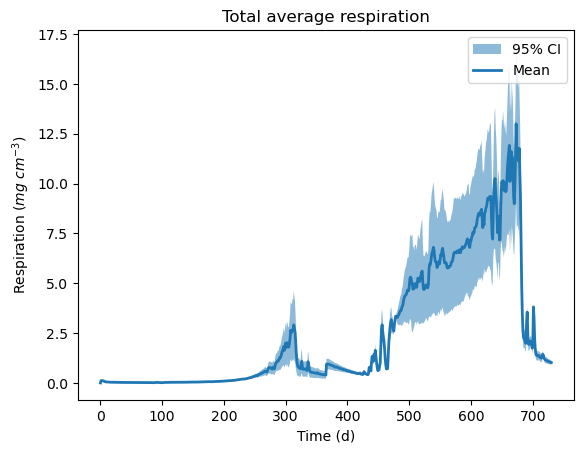

In [11]:
fig, ax = plt.subplots()

ax.fill_between(time,respiration_5,respiration_95, alpha=.5, linewidth=0,label="95% CI")
ax.plot(time,Respi_mean, linewidth=2,label="Mean")

plt.xlabel('Time (d)') 
plt.ylabel('Respiration ($mg$ $cm^{-3}$)') 
plt.title('Total average respiration') 
ax.legend()
fig.show()

In [12]:
Subst_tot = []

for i in tt:
    Subst_tot.append(test[int(i)].SubstratesSeries)

Sub_sum     = np.mean((np.array(Subst_tot).sum(axis=1)),axis=0)
Sub_05      = np.percentile((np.array(Subst_tot).sum(axis=1)),5,axis=0)
Sub_95      = np.percentile((np.array(Subst_tot).sum(axis=1)),95,axis=0)

C:\Users\lucia\AppData\Local\Temp\ipykernel_16888\3386710776.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


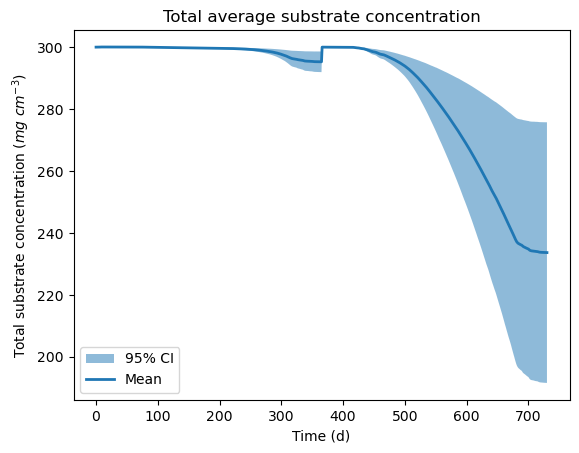

In [13]:
fig, ax = plt.subplots()

ax.fill_between(time,Sub_05/100,Sub_95/100, alpha=.5, linewidth=0,label="95% CI")
ax.plot(time,Sub_sum/100, linewidth=2,label="Mean")

plt.xlabel('Time (d)') 
plt.ylabel('Total substrate concentration ($mg$ $cm^{-3}$)') 
plt.title('Total average substrate concentration') 
ax.legend(loc="lower left")
fig.show()

In [14]:
(Sub_95[0]/100-Sub_95[365*2]/100)*100/(Sub_95[0]/100)

8.085738844906814

In [16]:
(Sub_05[0]/100-Sub_05[365*2]/100)*100/(Sub_05[0]/100)

36.14918771237259

In [17]:
(Sub_sum[0]/100-Sub_sum[365*2]/100)*100/(Sub_sum[0]/100)

22.117463278639697

In [18]:
Sub_sum[365*2]/100

233.6476101640809

In [21]:
test[int(0)].MicrobesSeries

,0,1,2,3,4,5,6,7,8,9,...,721,722,723,724,725,726,727,728,729,730
Tax1,2.0,1.976186,1.957336,1.943250,1.934199,1.929901,1.929913,1.934315,1.942816,1.956005,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Tax2,2.0,1.991774,1.984487,1.978102,1.972669,1.968124,1.964372,1.961413,1.959173,1.957777,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Tax3,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Tax4,1.0,0.980202,0.974805,0.982714,1.003843,1.037356,1.082320,1.138826,1.206413,1.286675,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Tax5,2.0,1.979979,1.969173,1.966793,1.972697,1.986032,2.005796,2.031716,2.063074,2.100548,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Tax6,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Tax7,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Tax8,2.0,1.986995,1.975864,1.966627,1.959468,1.954346,1.951139,1.949914,1.950582,1.953464,...,12.472553,12.719125,12.966457,13.213101,13.464088,13.710341,13.952343,14.206543,14.475186,14.741280
Tax9,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Tax10,2.0,1.991211,1.983308,1.976324,1.970363,1.965424,1.961461,1.958514,1.956548,1.955715,...,177.149106,178.179057,180.279434,179.037576,178.299529,180.336821,179.285776,181.321471,183.385265,185.461975


In [30]:
test[int(3)].SubstratesSeries

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
DeadMic,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.939327,1.933768,1.928535,1.923590,1.918842,1.914206,1.909769,1.905493,1.901365,1.897417
DeadEnz,0.0,0.0,0.000194,0.000571,0.001121,0.001834,0.002702,0.003717,0.004870,0.006154,...,0.328687,0.332920,0.337170,0.341417,0.345586,0.349594,0.353543,0.357398,0.361153,0.364857
Cellulose,14689.0,14689.0,14688.972637,14688.921479,14688.847285,14688.752160,14688.637223,14688.504037,14688.348742,14688.173803,...,14612.185734,14610.484003,14608.830575,14607.213435,14605.591371,14603.917794,14602.247852,14600.562747,14598.857762,14597.159562


In [13]:
test[int(3)].SubstratesSeries

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
DeadMic,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.258016,1.252656,1.247613,1.242850,1.238284,1.233836,1.229583,1.225491,1.221546,1.217778
DeadEnz,0.0,0.0,0.000194,0.000571,0.001120,0.001832,0.002698,0.003709,0.004857,0.006135,...,0.226091,0.228088,0.230084,0.232069,0.234008,0.235859,0.237675,0.239441,0.241152,0.242836
Cellulose,14689.0,14689.0,14688.972641,14688.921513,14688.847411,14688.752469,14688.637837,14688.505102,14688.350452,14688.176374,...,14638.558978,14637.716326,14636.904691,14636.117543,14635.334427,14634.532803,14633.739022,14632.943944,14632.145228,14631.355187


In [31]:
test[int(0)].MonomersSeries

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
NH4,0.0,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
PO4,0.0,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
DeadMic,0.0,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.064778,0.064416,0.063867,0.063162,0.062329,0.061386,0.060348,0.059229,0.058043,0.056805
DeadEnz,0.0,0.0,0.000000,3.348355e-08,1.789337e-07,5.531939e-07,0.000001,0.000003,0.000005,0.000007,...,0.004969,0.005059,0.005186,0.005340,0.005482,0.005573,0.005668,0.005750,0.005818,0.005897
Mon3,0.0,0.0,0.016497,4.720433e-02,9.122017e-02,1.471546e-01,0.213918,0.290245,0.377072,0.472671,...,27.262329,27.703449,28.129247,28.540520,28.941414,29.335537,29.718086,30.090298,30.452138,30.802223


In [14]:
test[int(0)].MonomersSeries

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
NH4,0.0,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
PO4,0.0,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
DeadMic,0.0,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.154542,0.156273,0.157671,0.158772,0.159625,0.160267,0.160684,0.160899,0.160925,0.160768
DeadEnz,0.0,0.0,0.000000,4.060776e-08,2.159501e-07,6.642724e-07,0.000002,0.000003,0.000005,0.000009,...,0.015473,0.015702,0.015932,0.016161,0.016378,0.016573,0.016759,0.016934,0.017096,0.017253
Mon3,0.0,0.0,0.017871,5.138307e-02,9.949798e-02,1.605759e-01,0.233526,0.317897,0.412920,0.517814,...,23.824359,24.118112,24.394543,24.656606,24.912806,25.172002,25.423618,25.671241,25.915681,26.152299


In [34]:
test[int(0)].MonomersSeries.T["Mon3"]

0       0.000000
1       0.000000
2       0.016497
3       0.047204
4       0.091220
         ...    
96     29.335537
97     29.718086
98     30.090298
99     30.452138
100    30.802223
Name: Mon3, Length: 101, dtype: float64

In [15]:
test[int(0)].MonomersSeries.T["Mon3"]

0       0.000000
1       0.000000
2       0.017871
3       0.051383
4       0.099498
         ...    
96     25.172002
97     25.423618
98     25.671241
99     25.915681
100    26.152299
Name: Mon3, Length: 101, dtype: float64